In [1]:
application = 'Watercare'

In [2]:
import sys 
import pathlib

In [3]:
from matplotlib import pyplot as plt 
import proplot as plot 

In [4]:
import pandas as pd

In [5]:
import geopandas as gpd 

In [6]:
import xarray as xr
import regionmask
import contextily as ctx

In [7]:
from cartopy import crs as ccrs

In [8]:
def make_stat(dset, varname=None, stat='mean', columns=['Hunuas','Waitakere']):
    if stat == 'mean': 
        dset = dset.groupby('mask').mean() 
    elif stat == 'min': 
        dset = dset.groupby('mask').min()
    elif stat == 'max': 
        dset = dset.groupby('mask').max()
    elif stat == 'sum': 
        dset = dset.groupby('mask').sum()
    df = dset[varname].to_dataframe()
    df = df.unstack().T
    df = df.droplevel(0, axis=0)
    df.columns = columns
    return df

In [9]:
HOME = pathlib.Path.home() 

### reads the shapefile for the HUNUAS and the WAITAKERE basins (merged), this has been created by the notebook `read_all_subs_creates_Hunuas_Waitakere_catchments.ipynb`

In [10]:
shapes = gpd.read_file('./HUNUAS_and_WAITAKERE.json')

### need to convert from lat/lon (WGS84, epsg 4326) to the New Zealand Grid Map (NZGD 1949 / EPSG 4272) to match the VCSN projection

In [11]:
shapes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
shapes = shapes.to_crs(epsg=4272)

In [13]:
shapes.crs

<Geographic 2D CRS: EPSG:4272>
Name: NZGD49
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: New Zealand - onshore and nearshore
- bounds: (165.87, -47.65, 179.27, -33.89)
Datum: New Zealand Geodetic Datum 1949
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [14]:
shapes

,GIS_ID,FAC_CODE,GRP,GRP_CODE,LAND_AREA,MSLINK,CREATEBY,CREATEDATE,MODIFYBY,MODIFYDATE,MODIFYREF,catchment,geometry
0,23630,SDCOS,SD,None,21478632.56,0,wsl,2006-04-13,wsl,2006-04-13,CameronKng,H,"POLYGON ((175.17764 -37.09305, 175.17855 -37.0..."
1,23639,None,SD,None,575982.03,0,wsl,2006-04-13,wsl,2006-04-13,CameronKng,W,"POLYGON ((174.58119 -36.97652, 174.58119 -36.9..."


In [15]:
dshape = shapes.to_crs(epsg=3857)

### plot with a basemap (using contextily)

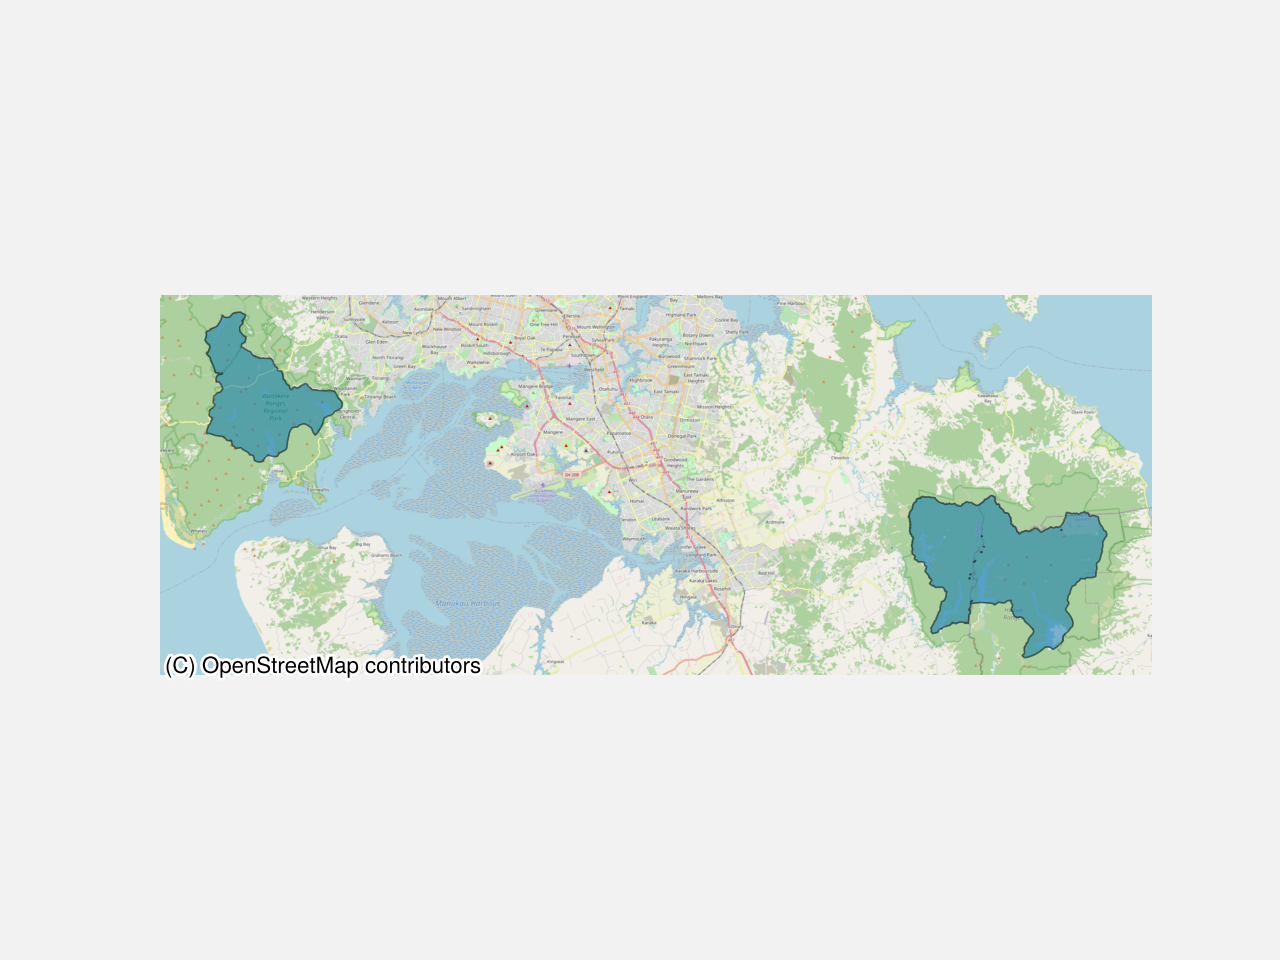

In [16]:
f, ax = plt.subplots()
dshape.plot(alpha=0.5, edgecolor='k',ax=ax)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
f.savefig('./basemap_plot_contextily.png', dpi=200, bbox_inches='tight')

In [17]:
regions_definitions = regionmask.from_geopandas(shapes, names='catchment')

<GeoAxesSubplot:>

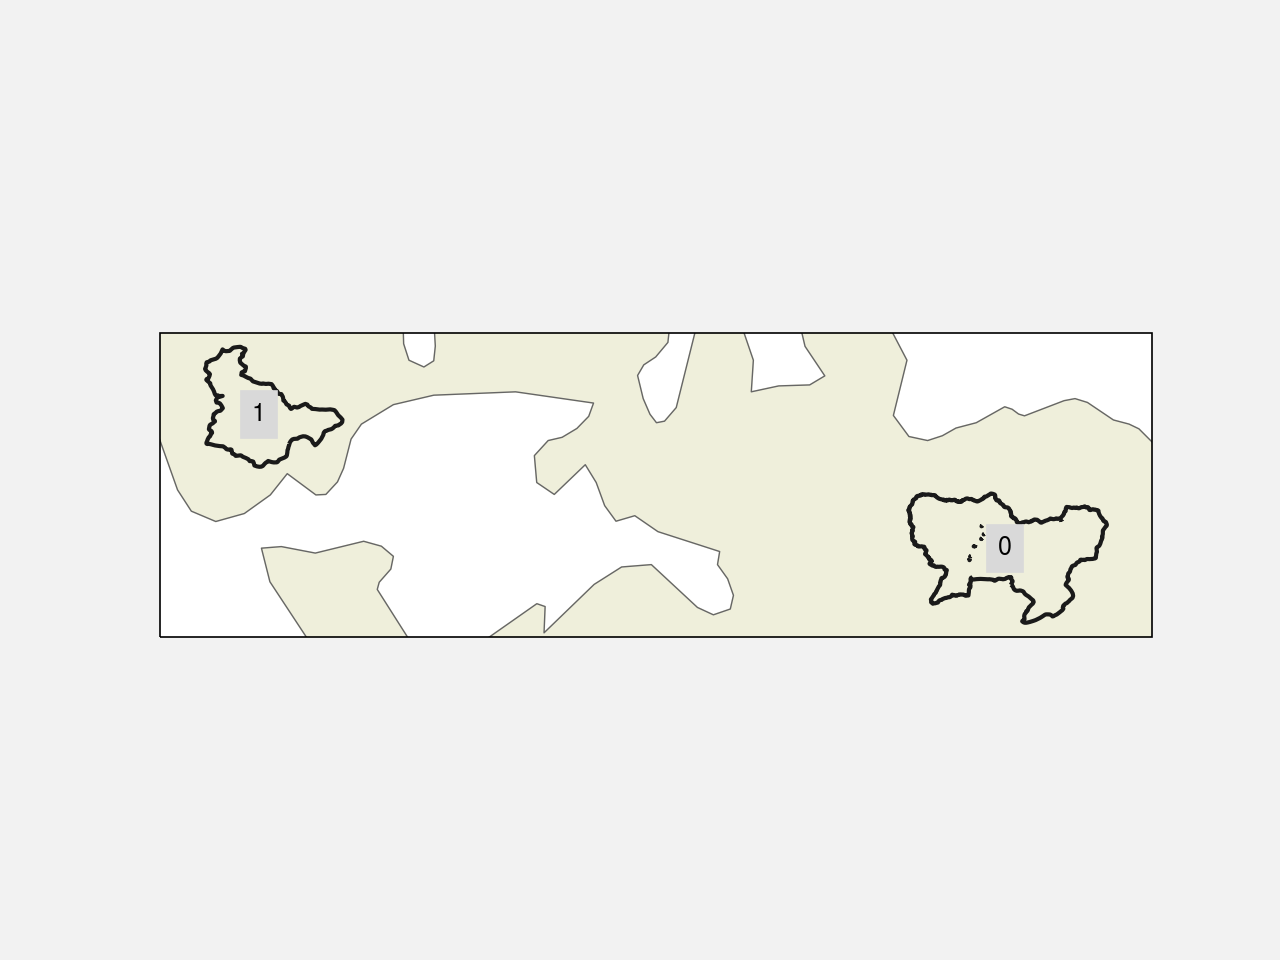

In [18]:
regions_definitions.plot(add_land=True, resolution='10m')

### get the min and max coordinates 

In [19]:
lonmin, latmin, lonmax, latmax = regions_definitions.bounds_global

### now read the VCSN DAILY values, and extract time-series 

In [20]:
dpath_vcsn = pathlib.Path('/home/nicolasf/operational/VCSN/data/NC/DAILY') 

### creates the dictionnary mapping variables (names in the file) to variables (name in the dataset )

In [21]:
variables_list = ['TMEAN_N', 'TMIN_N', 'TMAX_N', 'RAIN_BC', 'SOILM', 'RAD']

In [22]:
varnames_list  = ['Tmean_N', 'Tmin_N', 'Tmax_N', 'Rain_bc', 'SoilM', 'Rad']

In [23]:
var_dict = dict(zip(variables_list, varnames_list))

In [24]:
var_dict

{'TMEAN_N': 'Tmean_N',
 'TMIN_N': 'Tmin_N',
 'TMAX_N': 'Tmax_N',
 'RAIN_BC': 'Rain_bc',
 'SOILM': 'SoilM',
 'RAD': 'Rad'}

In [25]:
rpath = HOME.joinpath(f'research/Smart_Ideas/outputs/targets/application_cases/{application}')

### loop over the variables, extract and saves to disk the DAILY raw values 

In [26]:
for varname in variables_list: 

    opath = rpath.joinpath(varname)
    
    if not opath.exists(): 
        opath.mkdir(parents=True)
    
    print(f"extracting and processing {varname}")

    ### get the list of files 
    lfiles = list(dpath_vcsn.joinpath(varname).glob("VCSN_gridded_daily*_????-??.nc"))

    lfiles.sort()

    ### read 
    vcsn_dset = xr.open_mfdataset(lfiles, concat_dim='time', parallel=True)
    
    ### extract the bounding box 
    sub_vcsn = vcsn_dset.sel(lon=slice(lonmin-0.5, lonmax+0.5), lat=slice(latmin-0.5, latmax+0.5))
    
    ### make the mask 
    mask = regions_definitions.mask(sub_vcsn.lon, sub_vcsn.lat) 
    
    ### insert the mask in the vcsn dataset 
    sub_vcsn['mask'] = mask
    
    ### drop the agent numbers from the dataset 
    if 'agent' in sub_vcsn.variables:
        sub_vcsn = sub_vcsn.drop('agent')
    
    ### calculate the average, min, max, and sum 
    for stat in ['mean','min','max','sum']: 
        df = make_stat(sub_vcsn, varname=var_dict[varname], stat=stat)
        ### saves to disk 
        df.to_csv(opath.joinpath(f"daily_{stat}_{varname}.csv"))
    
    sub_vcsn.close()
    
    vcsn_dset.close()
        

extracting and processing TMEAN_N
extracting and processing TMIN_N
extracting and processing TMAX_N
extracting and processing RAIN_BC
extracting and processing SOILM
extracting and processing RAD


In [58]:
df

,INTERSECT,IN,new
time,,,
1979-01-01,0.0,0.0,0.0
1979-01-02,0.0,0.0,0.0
1979-01-03,23.5,10.9,10.9
1979-01-04,0.0,0.0,0.0
1979-01-05,0.0,0.0,0.0
...,...,...,...
2019-12-27,0.0,0.0,0.0
2019-12-28,0.0,0.0,0.0
2019-12-29,0.0,0.0,0.0
